In [9]:
%pip install numpy, pandas, matplotlib, scipy, scikit-learn, spei, seaborn

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'numpy,'

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy.stats as scs
from scipy.stats import genextreme, pearson3
from scipy.optimize import curve_fit
from scipy.stats import genextreme as gev
from scipy.stats import pearson3
from sklearn.preprocessing import StandardScaler
import spei as si


In [28]:
def get_drought_metrics(ssi):
    """Get drought start and end dates, magnitude, severity, and duration.

    Args:
        ssi (pd.Series): Array of SSI values.  

    Returns:
        pd.DataFrame: DataFrame containing all drought metrics for each drought period.
    """
    
    drought_data = {}
    drought_counter = 0
    in_critical_drought = False
    drought_days = []

    for ind in range(len(ssi)):
        if ssi.values[ind] < 0:
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':ssi.index[drought_days[0]],
                    'end': ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(ssi.values[drought_days]),
                    'severity': min(ssi.values[drought_days])
                }
            
            # Reset counters
            in_critical_drought = False
            drought_days = [] 

    drought_metrics = pd.DataFrame(drought_data).transpose()
    return drought_metrics



This function is going to look at the droughts, and then calculate a few different variables of interest... 

In [29]:

def drought_metric_scatter_plot(drought_metrics):
    fig, ax = plt.subplots(figsize = (7,6))
    p = ax.scatter(drought_metrics['severity'], -drought_metrics['magnitude'],
            c= drought_metrics['duration'], cmap = 'viridis_r', s=100)

    plt.colorbar(p).set_label(label = 'Drought Duration (days)',size=15)
    plt.xlabel(r'Severity ($Minimum SSI_{6}$)', fontsize = 15)
    plt.ylabel(r'Magnitude (Acc. Deficit)', fontsize = 15)
    plt.title(f'Historic Droughts', fontsize = 16)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    return


The next function is used to make a fancy timeseries plot... don't worry about how it works for now. 

In [ ]:
def plot_ssi(ssi, bound = 3.0, figsize= (8, 4), ax = None, gradient = False):
    """Plot the standardized index values as a time series. 
    Modified from https://github.com/martinvonk/SPEI/blob/main/src/spei/plot.py

    Parameters
    ----------
    si : pandas.Series
        Series of the standardized index
    bound : int, optional
        Maximum and minimum ylim of plot
    figsize : tuple, optional
        Figure size, by default (8, 4)
    ax : matplotlib.Axes, optional
        Axes handle, by default None which create a new axes

    Returns
    -------
    matplotlib.Axes
        Axes handle
    """
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    ax.plot(ssi, color="k", lw = 1, label="SSI")
    ax.axhline(0, linestyle="--", color="k")

    nmin = -bound
    nmax = bound
    # Classify droughts
    in_drought = False
    in_critical_drought = False

    droughts = np.zeros_like(ssi.values)
    drought_days = []
    drought_counter = 0
    for ind in range(len(droughts)):
        if ssi.values[ind] < 0:
            in_drought = True
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
                droughts[drought_days] = 1
        else:
            in_drought = False
            in_critical_drought = False
            drought_days = [] 
            drought_counter = 0
        
    if gradient:
        droughts = ssi.to_numpy(dtype=float, copy=True)
        droughts[droughts > 0] = 0
        nodroughts = ssi.to_numpy(dtype=float, copy=True)
        nodroughts[nodroughts < 0] = 0
        x, y = np.meshgrid(ssi.index, np.linspace(nmin, nmax, 100))
        ax.contourf(
            x, y, y, cmap=plt.get_cmap("seismic_r"), levels=np.linspace(nmin, nmax, 100)
        )
        ax.fill_between(x=ssi.index, y1=droughts, y2=nmin, color="w")
        ax.fill_between(x=ssi.index, y1=nodroughts, y2=nmax, color="w")
    else:
        ax.fill_between(x=ssi.index, y1=nmax, y2=nmin, where=(droughts>0), color='red', alpha=0.5, interpolate=False, label = 'Drought Period')
    ax.set_ylim(nmin, nmax)
    return ax

In [18]:
# Load data
flow = pd.read_csv('Data/streamflow.csv', index_col=0, parse_dates=True)

station_id = flow.columns[0]

# View to make sure it worked
flow.head()

,USGS-04234000
1925-02-15,4.336560
1925-02-16,2.930916
1925-02-17,2.938393
1925-02-18,2.100988
1925-02-19,1.996313


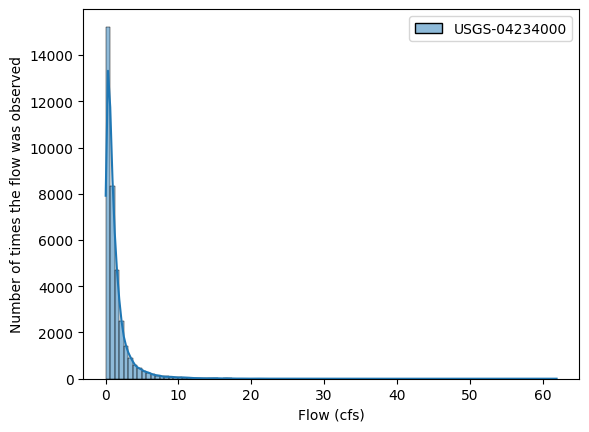

In [14]:
# Make the figure
fig, ax = plt.subplots()

# Should we use log flow or regular flow?
use_log_flow = False
if use_log_flow:
    data = np.log(flow)
    y_label = 'Log Flow (cfs)'
else:
    data = flow
    y_label = 'Flow (cfs)'

# Use SeaBorn to make a histogram
sns.histplot(data, ax = ax, 
             color = 'cornflowerblue', 
             bins = 100, kde=True)

# Set the x and y axes labels
plt.ylabel('Number of times the flow was observed')
plt.xlabel(y_label)
plt.show()

Recall that when we calculate droughts we need to set the "rolling window" size... this is going to have an impact on the droughts that we find.  If the window is very small, then the droughts will be insignificant.  If the window is very big, then we will identify only very big droughts.  

In the next cell, we do the following:
1. Set the rolling window size
2. Calculate the rolling sum
3. Calculate the SSI
4. Plot the time periods which are identified as droughts.

<Axes: >

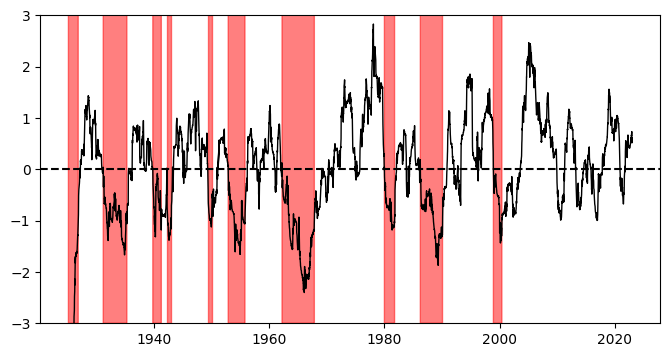

In [25]:
# Calculate the rolling sum of flow
ssi_window = "720D"
rolling_sum = flow.rolling(window = ssi_window).sum().dropna()

# Calculate SSI values
ssi_values = si.ssfi(rolling_sum, dist = scs.gamma)

plot_ssi(ssi_values)

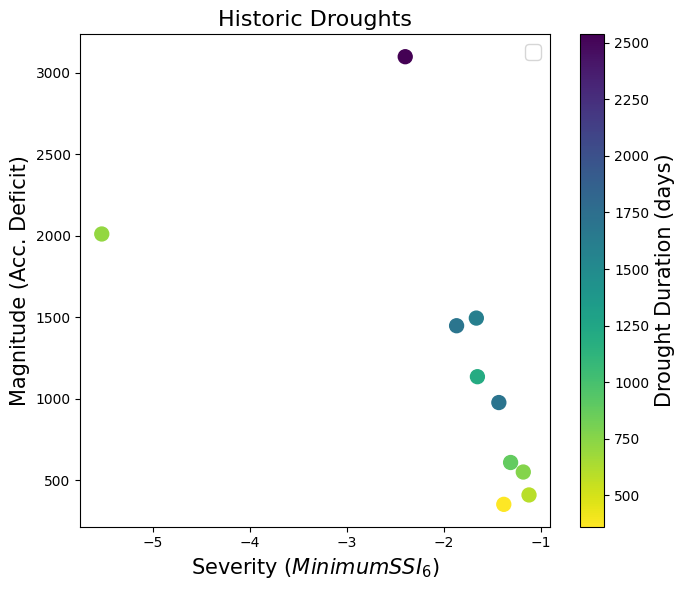

In [26]:
drought_metrics = get_drought_metrics(ssi_values)

drought_metric_scatter_plot(drought_metrics)